In [11]:
import pandas as pd
import holidayapi
import calendarific
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import calendarific
import numpy as np
from sklearn.metrics import mean_squared_error

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

# Step 1:
* To demonstrate your ability to integrate data from multiple sources, use the
API below to add information about national holidays to the dataset
* Given the date and country of each transaction, use the API to
determine whether it was a national holiday

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.



In [ ]:
file = "Online Retail.xlsx"
#file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

df = pd.read_excel(file,dtype={"CustomerID":str}, parse_dates=["InvoiceDate"])

In [ ]:
data = df.copy()

In [ ]:
data["InvoiceDate"] = data["InvoiceDate"].apply(lambda x: x.date())
data["Holiday"] = np.nan

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description:** Product (item) name. Nominal.  
**Quantity:** The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.  
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.  
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country:** Country name. Nominal, the name of the country where each customer resides.  

## Superficial check and minor data transformations

In [ ]:
data.sample(10)

In [ ]:
data.describe(include="all")

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
#distinct countries in an array so a long column is not generated
np.array(set(data.Country))

In [ ]:
fig = plt.figure(figsize=(40,10)) 
fig_dims = (4, 2)

plt.subplot2grid(fig_dims, (0, 0))
data['Country'].value_counts().plot(kind='bar', 
                                     title='Country distribution')

plt.subplot2grid(fig_dims, (2, 0))
data['Country'][data.Country != "United Kingdom"].value_counts().plot(kind='bar', 
                                     title='Country distribution w/o UK')

As Unspecified and European Community are to generic to be usefull and represent few cases (0.08% of data), we won't take them into account

In [ ]:
{i:len(data[data["Country"]== i]) for i in ['European Community','Unspecified']}


In [ ]:
#data = data[((data.Country !='European Community') | (data.Country != "Unspecified"))]
data = data[(data.Country !='European Community')&(data.Country !='Unspecified')]

----

In [ ]:
data.head()

## Holidays data from API

### 1st aproach

In [ ]:
hapi = holidayapi.v1('d50020d6-e887-4a32-bbe5-ba18f05f6877')

parameters = {
    # Required
    'country': 'US',
    'year':    2010,
    # Optional
    # 'month':    7,
    # 'day':      4,
    # 'previous': True,
    # 'upcoming': True,
    # 'public':   True,
    # 'pretty':   True,
}

holidays = hapi.holidays(parameters)

In [ ]:
holidays.head()

As this api is limited to 2018, we look for a different api

### 2nd aproach

In [ ]:
#Install from github, not from pip. In pip version, *has_key* command is used, which was deprecated for *in* comand

#https://calendarific.com/ 

#!pip install python-calendarific

In [ ]:
import calendarific

API_key = '3b7f1ee4d80cebbfb6f9d7cfcef868c1b97ddcdb'
calapi = calendarific.v2(API_key)

parameters = {'country': 'sg','year':    2011,}

In [ ]:
us_holidays = calapi.holidays(parameters)

In [ ]:
us_holi_dict = pd.DataFrame.from_dict(us_holidays["response"]["holidays"])
us_holi_dict.head()

as we see, we will have to adapt country names to "ISO 3166-1 alpha-2 code" to feed the API.

In [ ]:
#we do this manually, thus we could extract from API website or Wikipedia through a scrapper

Country_ISO_dict = {
    'Australia': "AU",
    'Austria': "AT",
    'Bahrain':"BH",
    'Belgium': "BE",
    'Brazil': "BR",
    'Canada': "CA",
    'Cyprus':"CY",
    'Czech Republic':"CZ",
    'Channel Islands': "GB",
    'Denmark': "DK",
    'EIRE': "IE",
    'Finland':"FI",
    'France':"FR",
    'Germany':"DE",
    'Greece':"GR",
    'Hong Kong':"HK",
    'Iceland':"IS",
    'Israel':"IL",
    'Italy':"IT",
    'Japan':"JP",
    'Lebanon':"LB",
    'Lithuania':"LT",
    'Malta':"MT",
    'Netherlands':"NL",
    'Norway':"NO",
    'Poland':"PL",
    'Portugal':"PT",
    'RSA':"ZA",
    'Saudi Arabia':"SA",
    'Singapore':"SG",
    'Spain':"ES",
    'Sweden':"SE",
    'Switzerland':"CH",
    'USA':"US",
    'United Arab Emirates':"AE",
    'United Kingdom':"GB",
}

we create a function to extract data from API and preprocess it

In [ ]:
def holidays_API (Country, year, all_holidays = True):
    """
    
    Returns a dataset with national holidays listed and aditional info
    if holiday set to True, all holidays are taken into account
    
    """
    
    #as there is no data through the API for Bahrein till 2015, 
    #we use 2021 for 2010 and 2022 for 2011 as these years have the same day distribution
    
    if Country == "BH":
        if year == 2010:
            year = 2021
            
        elif year ==2011:
            year = 2022
            
    
    #api parameters
    API_key = '3b7f1ee4d80cebbfb6f9d7cfcef868c1b97ddcdb'
    calapi = calendarific.v2(API_key)
    parameters = {'country': Country,'year':year,}
    
    holidays = pd.DataFrame.from_dict(calapi.holidays(parameters)["response"]["holidays"])
    
    #dataset prep
    holidays["Holiday"] = True
    holidays["date"] = holidays["date"].apply(lambda x: x["iso"])
    
    if all_holidays == True:
        pass
    else:
        holidays["types"] = holidays["type"].apply(lambda x: "".join(x))
        holidays = holidays[holidays["types"] == "National holiday"]
    
    
    #as some values come back as a 2011-12-22T00:30:02-05:00, we trim it
    holidays["date"] = holidays["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date() if len(x)==10 
                                              else datetime.datetime.strptime(x[:10], "%Y-%m-%d").date())
    
    return holidays[["date","Holiday" ]]

this fuction will evaluate holidays for every date and country in a given dataset

In [ ]:
def validate_holidays(data, all_holidays = False):
    """
    For a given dataset (in this exercise), it returs true or false in a new column whether that date was national holiday or not.
    
    Parameters:
    
        data: Dataset with a Country field
        all_holidays:False by default. If true, all holiday types are taken into account
        
    """
    print(all_holidays)
    for year in (2010,2011):
        print(year)
        for i in tqdm(set(data.Country)):
            data.loc[data["Country"] == i, "Holiday"] = data.InvoiceDate.isin(holidays_API(Country_ISO_dict[i],year, all_holidays).date)
    
    return data

As many holidays are not national but could affect purchasing behaviours, we create two dataset to be used and compared in the next exercise

In [ ]:
#all holiday type
sales_allH = validate_holidays(data.copy(), all_holidays = True)

#only national holidays
sales_NH = validate_holidays(data.copy(), all_holidays = False)

In [ ]:
#some data saving
sales_NH.to_csv("sales_NH.csv", mode = "w")
sales_allH.to_csv("sales_allH.csv", mode = "w")

In [ ]:
fig = plt.figure(figsize=(10,10)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
sales_allH['Holiday'].value_counts().plot(kind='bar', 
                                     title='all holidays')
plt.subplot2grid(fig_dims, (0, 1))
sales_NH['Holiday'].value_counts().plot(kind='bar', 
                                     title='national holidays')

______

# Step 2:
To demonstrate your ability to do predictive modeling, demonstrate to us how
you would go about forecasting daily sales  
* Given this retailer’s 2010-2011 transactions in the datatest, predict the
amount (€) this retailer will sell each day of 2012

In [3]:
#all holidays
sales_allH = pd.read_csv("sales_allH.csv", index_col = 0, dtype={"CustomerID":str})

sales_allH["InvoiceDate"] = pd.to_datetime(sales_allH["InvoiceDate"], format='%Y-%m-%d')
sales_allH["Benefit"] = sales_allH["Quantity"] * sales_allH["UnitPrice"]


In [38]:
#national holidays
sales_NH = pd.read_csv("sales_NH.csv", index_col = 0, dtype={"CustomerID":str})

sales_NH["InvoiceDate"] = pd.to_datetime(sales_NH["InvoiceDate"], format='%Y-%m-%d')
sales_NH["Benefit"] = sales_NH["Quantity"] * sales_NH["UnitPrice"]

## Feature validation

In [4]:
def filter_by_condition(data,condition):
    """
    
    For a given Dataset and condition, returns the dataset without entries matching the condition 
    Also, prints the amount of entries before and after filtering and the difference
    
    Parameters:
    ----------
    data: Any dataset
    condition: column selection and condition to be matched in that column
    
    """
    len_data = len(data)
    data = data[condition]
    
    print("total entries", len_data, 
      ", remaining entries", len(data), 
      ", Dif:", len_data - len(data))
    return data

### **InvoiceNo:** 
those which start with "C" are cancellations, that so, we will asume that what's relevant is the original buy prior to later back down. So we erase them:

In [5]:
canc_filter = ~sales_allH.InvoiceNo.str.startswith('C')

sales_allH = filter_by_condition(sales_allH, canc_filter)


total entries 541402 , remaining entries 532115 , Dif: 9287


### **StockCode:** 
Supposedly to be only a number, pandas has determined to be an object, so it might not be true

In [6]:
#not numbers
NoNumb = pd.to_numeric(sales_allH.StockCode, errors="coerce").isna()

NoNumb.sum()

53596

In [7]:
sales_allH.StockCode[NoNumb][:10]

#so mainly number and a letter...

0     85123A
2     84406B
3     84029G
4     84029E
45      POST
49    85123A
51    84406B
60    82494L
61    84029G
62    84029E
Name: StockCode, dtype: object

In [8]:
#ok, appart from number+letter
StockCodeWords = set(sales_allH.StockCode[~sales_allH.StockCode.str.contains("[$0-9]")])
StockCodeWords

{'AMAZONFEE',
 'B',
 'BANK CHARGES',
 'DCGSSBOY',
 'DCGSSGIRL',
 'DOT',
 'M',
 'PADS',
 'POST',
 'S',
 'm'}

In [9]:
example = pd.DataFrame()
for i in StockCodeWords:
    example = example.append(sales_allH[sales_allH.StockCode == i].head(1))

In [10]:
example

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Holiday,Benefit
40383,539736,m,Manual,1,2010-12-21,2.550,NaN,United Kingdom,False,2.550
299982,A563185,B,Adjust bad debt,1,2011-08-12,11062.060,NaN,United Kingdom,False,11062.060
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15,0.001,13952,United Kingdom,False,0.001
152709,549684,S,SAMPLES,1,2011-04-11,30.000,NaN,United Kingdom,False,30.000
45,536370,POST,POSTAGE,3,2010-12-01,18.000,12583,France,False,54.000
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2011-02-07,3.290,NaN,United Kingdom,False,3.290
4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02,15.000,15823,United Kingdom,False,15.000
2239,536569,M,Manual,1,2010-12-01,1.250,16274,United Kingdom,False,1.250
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07,13541.330,NaN,United Kingdom,False,13541.330
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2011-02-07,3.290,NaN,United Kingdom,False,9.870


In [11]:
{i:len(sales_allH[sales_allH.StockCode == i]) for i in StockCodeWords}

{'m': 1,
 'B': 3,
 'PADS': 4,
 'S': 2,
 'POST': 1127,
 'DCGSSBOY': 11,
 'BANK CHARGES': 12,
 'M': 327,
 'AMAZONFEE': 2,
 'DCGSSGIRL': 13,
 'DOT': 709}

In [12]:
not_code_filter = ~sales_allH.StockCode.isin(list(StockCodeWords))
print("Income from unmapped data: ",sum(sales_allH.Benefit[~not_code_filter]))

Income from unmapped data:  365544.5340000003


whilst "DCGSSBOY", "DCGSSGIRL", "M" and "m" seem to be products sold, rest of this Codes might be some other . 

In any case, we don't have further data to confirm this asumption and despite being few entries for 366k£, we won't consider them for the model.

In [13]:
sales_allH = filter_by_condition(sales_allH, not_code_filter)

total entries 532115 , remaining entries 529904 , Dif: 2211


###  **Quantity:** 
Numeric field (in this case it's confirmed by column type - int)... could there be any negative values? what could they mean?

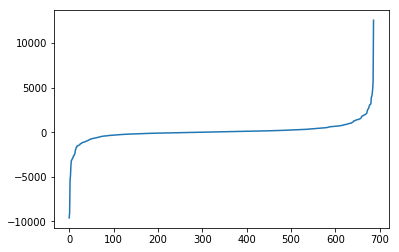

In [14]:
#as there is a long tail, we filter to visualize the data
plt.plot(sales_allH.Quantity[sales_allH.Quantity<20000].sort_values().unique())

In [15]:
sales_allH[sales_allH.Quantity<0].sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Holiday,Benefit
185168,552767,79164,NaN,-47,2011-05-11,0.0,NaN,United Kingdom,False,-0.0
472844,576767,22339,check,-60,2011-11-16,0.0,NaN,United Kingdom,False,-0.0
148106,549170,82545A,NaN,-4,2011-04-06,0.0,NaN,United Kingdom,False,-0.0
418063,572684,23029,damages,-20,2011-10-25,0.0,NaN,United Kingdom,False,-0.0
150153,549343,72815,NaN,-3,2011-04-08,0.0,NaN,United Kingdom,False,-0.0
148563,549244,79331,NaN,-3,2011-04-07,0.0,NaN,United Kingdom,False,-0.0
114535,546021,85175,dotcom sold sets,-345,2011-03-08,0.0,NaN,United Kingdom,True,-0.0
418127,572699,72818,NaN,-48,2011-10-25,0.0,NaN,United Kingdom,False,-0.0
149043,549264,21337,NaN,-21,2011-04-07,0.0,NaN,United Kingdom,False,-0.0
203752,554551,47566B,reverse previous adjustment,-1300,2011-05-25,0.0,NaN,United Kingdom,False,-0.0


It seems negative quantity values are meant to represent inventary corrections or mistakes, so it should not affect sales predictions

In [16]:
neg_quantity_filter = ~sales_allH.Quantity<0
sales_allH = filter_by_condition(sales_allH, neg_quantity_filter)

total entries 529904 , remaining entries 528568 , Dif: 1336


### UnitPrice
Numeric field (float). negative values? outliers?

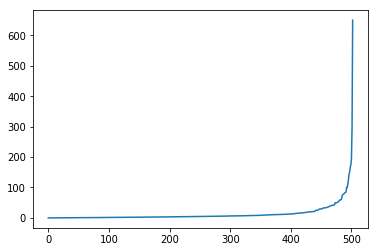

In [17]:
plt.plot(sales_allH.UnitPrice.sort_values().unique())

seems normal...

### Benefit
it should be normal since we checked UnitPrice and Quantity variables

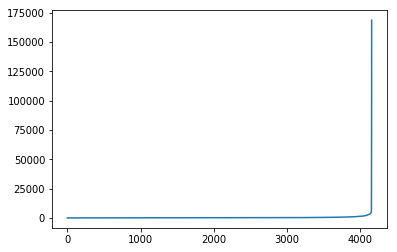

In [18]:
plt.plot(sales_allH.Benefit.sort_values().unique())

In [19]:
sales_allH[sales_allH.Benefit > 4000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Holiday,Benefit
52134,540689,22470,HEART OF WICKER LARGE,1284,2011-01-11,3.21,17450,United Kingdom,False,4121.64
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11,2.55,15749,United Kingdom,False,4921.50
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11,2.10,15749,United Kingdom,False,6539.40
52772,540818,48185,DOORMAT FAIRY CAKE,670,2011-01-11,6.75,15749,United Kingdom,False,4522.50
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346,United Kingdom,False,77183.60
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18,2.40,15749,United Kingdom,False,4632.00
160544,550461,48185,DOORMAT FAIRY CAKE,670,2011-04-18,6.35,15749,United Kingdom,False,4254.50
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18,2.10,15749,United Kingdom,False,6539.40
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10,649.50,15098,United Kingdom,False,38970.00
244419,558526,23173,REGENCY TEAPOT ROSES,540,2011-06-30,8.15,17949,United Kingdom,False,4401.00


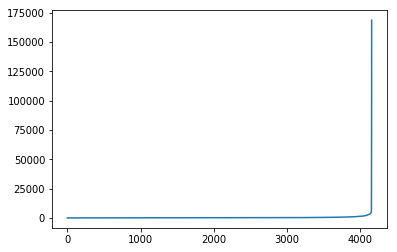

In [20]:
plt.plot(sales_allH.Benefit.sort_values().unique())

In [21]:
sales_allH.Benefit.sort_values(ascending = False)[:10]

540421    168469.60
61619      77183.60
222680     38970.00
348325      7144.72
52711       6539.40
160546      6539.40
421601      4992.00
52709       4921.50
467804      4781.60
160542      4632.00
Name: Benefit, dtype: float64

In [27]:
#a grouping by daily benefits mean its done so no outliers might afect deeply our model.

clean_sales_allH = sales_allH.copy().groupby(["InvoiceDate", "Country", "Holiday"]).mean().reset_index()

In [31]:
clean_sales_allH = clean_sales_allH.set_index("InvoiceDate")

In [36]:
clean_sales_allH.describe(include="all")

,Country,Holiday,Quantity,UnitPrice,Benefit
count,1513,1513,1513.000000,1513.000000,1513.000000
unique,36,2,NaN,NaN,NaN
top,United Kingdom,False,NaN,NaN,NaN
freq,305,1362,NaN,NaN,NaN
mean,NaN,NaN,24.020937,3.284246,42.099859
std,NaN,NaN,77.813605,2.110247,150.860057
min,NaN,NaN,1.000000,0.402000,1.224444
25%,NaN,NaN,8.673870,2.294151,16.550000
50%,NaN,NaN,11.426667,2.962667,20.277778
75%,NaN,NaN,16.535714,3.679512,28.914286


In [37]:
clean_sales_allH.to_csv("clean_sales_allH.csv")

In [46]:
#same processing for only national holidays dataset

StockCodeWords_NH = set(sales_NH.StockCode[~sales_NH.StockCode.str.contains("[$0-9]")])
conditions = [~sales_NH.InvoiceNo.str.startswith('C'), 
              ~sales_NH.StockCode.isin(list(StockCodeWords_NH)), 
              ~sales_NH.Quantity<0]

for i in conditions:
    sales_NH = filter_by_condition(sales_NH, i)

total entries 541402 , remaining entries 532115 , Dif: 9287


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


total entries 532115 , remaining entries 529904 , Dif: 2211
total entries 529904 , remaining entries 528568 , Dif: 1336


In [47]:
clean_sales_NH = sales_NH.copy().groupby(["InvoiceDate", "Country", "Holiday"]).mean().reset_index()
clean_sales_NH = clean_sales_NH.set_index("InvoiceDate")

clean_sales_NH.to_csv("clean_sales_NH.csv")

## Lets predict!

2.1. Baseline: Average  
2.2. ML  
2.3. time series decomposition  

**next steps**
* feature engineering: lags (weekly, monthly...), national/all holidays, 
countries (one hot encoding)
* use test data to optimize hiperparameters
* time series decomposition and prediction (Arima)


In [323]:
clean_sales_allH = pd.read_csv("clean_sales_allH.csv", index_col = "InvoiceDate", parse_dates = True).sort_index()
clean_sales_NH = pd.read_csv("clean_sales_NH.csv", index_col = "InvoiceDate", parse_dates = True).sort_index()

**2.1 Average**

In [634]:
data = clean_sales_allH.copy()

In [635]:
data = data.resample("D").mean()

In [636]:
def create_X_and_y(Xy, target_column='Benefit'):
    return Xy.index, Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy[Xy.index < Xy.index[int(len(Xy.index)/100*60)]]) #60% of data
    X_dev, y_dev = create_X_and_y(Xy[(Xy.index < Xy.index[int(len(Xy.index)/100*80)]) 
                                     & (Xy.index > Xy.index[int(len(Xy.index)/100*60)])]) #between 60 and 80% of data
    X_test, y_test = create_X_and_y(Xy[Xy.index > Xy.index[int(len(Xy.index)/100*80)]]) #above 80% of data
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(pd.DataFrame(data))

In [637]:
y_dev_avg = np.ones(len(y_dev)) * y_train.mean()

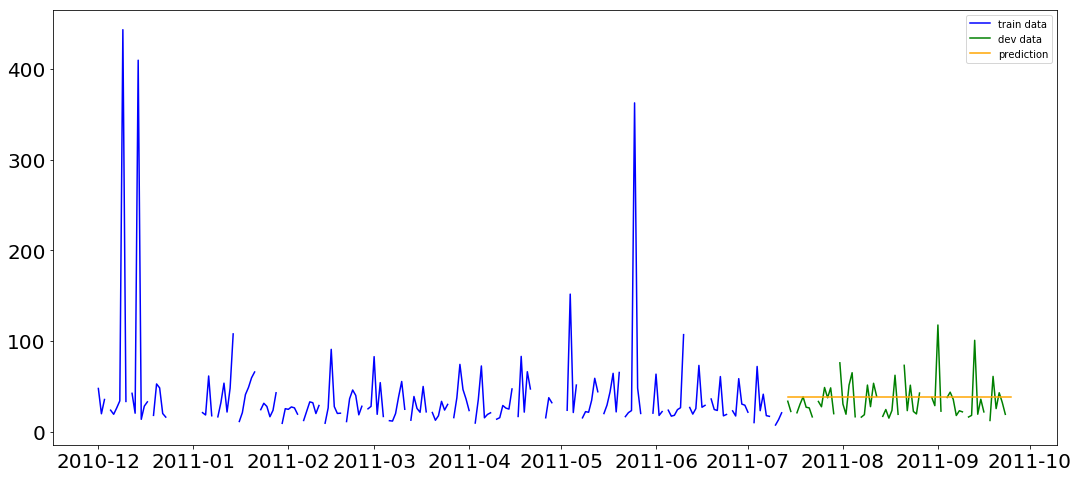

In [638]:
def plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_avg):
    plt.plot(X_train, y_train, c="blue", label='train data')
    plt.plot(X_dev, y_dev, c="green", label='dev data')
    plt.plot(X_dev, y_dev_avg, c="orange", label='prediction')
    
    plt.legend()
    plt.show()
    
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_avg)

In [18]:
print("MSE: " ,mean_squared_error(y_dev, y_dev_avg))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_avg)))

MSE:  452.29534301668247
RMSE:  21.267236374684003


#### ML: Random Forest

In [477]:
data = clean_sales_allH.copy()

In [478]:
data.head()

,Country,Holiday,Quantity,UnitPrice,Benefit
InvoiceDate,,,,,
2010-12-01,Australia,False,7.642857,5.278571,25.589286
2010-12-01,EIRE,False,11.571429,6.363810,26.446667
2010-12-01,France,False,23.473684,1.962632,42.203158
2010-12-01,Germany,False,11.142857,1.883571,17.391429
2010-12-01,Netherlands,False,96.000000,1.850000,177.600000


In [479]:
data.drop(["Quantity", "UnitPrice"], axis = 1, inplace = True)

In [480]:
#one hot encoding on countries. 36 countries, might generate excesive sparsity. 
#Would be interesting to try the model w/o this step
data = pd.get_dummies(data)

In [481]:
#not every day listed. data is grouped by day (avg on data). 
#NaN values swiched to 0, as it would have if no sales were made that day
data = data.resample("D").mean()
data.fillna(0, inplace=True)

In [482]:
#create extra data columns
data["day"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year
data["week"] = data.index.weekofyear
data["weekday"] = data.index.dayofweek

In [483]:
data.head()

,Holiday,Benefit,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,day,month,year,week,weekday
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01,0.0,47.686885,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.142857,1,12,2010,48,2
2010-12-02,0.0,19.807170,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,2,12,2010,48,3
2010-12-03,0.0,35.536370,0.000000,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.100000,3,12,2010,48,4
2010-12-04,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,4,12,2010,48,5
2010-12-05,0.0,23.763326,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.200000,5,12,2010,48,6


In [484]:
y = data["Benefit"]
X = data[['Holiday', 'day', 'month', 'year', 'week', 'weekday',
       'Country_Australia', 'Country_Austria', 'Country_Bahrain',
       'Country_Belgium', 'Country_Brazil', 'Country_Canada',
       'Country_Channel Islands', 'Country_Cyprus', 'Country_Czech Republic',
       'Country_Denmark', 'Country_EIRE', 'Country_Finland', 'Country_France',
       'Country_Germany', 'Country_Greece', 'Country_Hong Kong',
       'Country_Iceland', 'Country_Israel', 'Country_Italy', 'Country_Japan',
       'Country_Lebanon', 'Country_Lithuania', 'Country_Malta',
       'Country_Netherlands', 'Country_Norway', 'Country_Poland',
       'Country_Portugal', 'Country_RSA', 'Country_Saudi Arabia',
       'Country_Singapore', 'Country_Spain', 'Country_Sweden',
       'Country_Switzerland', 'Country_USA', 'Country_United Arab Emirates',
       'Country_United Kingdom']]


In [488]:
train_x, test_x, train_y, test_y = train_test_split(np.array(X), y,test_size = 0.4, shuffle = False)

In [490]:
dev_x, test_x, dev_y, test_y = train_test_split(test_x, test_y,test_size = 0.5, shuffle = False)

In [492]:
[print(i.shape) for i in [train_x, train_y, dev_x, dev_y, test_x, test_y]]

(224, 42)
(224,)
(75, 42)
(75,)
(75, 42)
(75,)


[None, None, None, None, None, None]

In [493]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [494]:
rf_model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [495]:
pred_y = rf_model.predict(dev_x)

In [500]:
print("MSE: " ,mean_squared_error(dev_y, pred_y))
print("RMSE: ", np.sqrt(mean_squared_error(dev_y, pred_y)))

MSE:  854.0774701173513
RMSE:  29.22460384876673


In [501]:
errors = abs(pred_y - dev_y)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 14.93


In [506]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / dev_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: 44.77 %.


**linear regresion**

In [534]:
from sklearn.linear_model import LinearRegression

In [535]:
data = clean_sales_allH["Benefit"].resample('D').mean()
data.fillna(0, inplace = True)
data = data.reset_index()

In [536]:
import numpy as np
from sklearn.model_selection import train_test_split

In [572]:
def create_X_and_y(Xy, target_column='Benefit'):
    return Xy.index, Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy[Xy.index < Xy.index[int(len(Xy.index)/100*60)]]) #60% of data
    X_dev, y_dev = create_X_and_y(Xy[(Xy.index < Xy.index[int(len(Xy.index)/100*80)]) 
                                     & (Xy.index > Xy.index[int(len(Xy.index)/100*60)])]) #between 60 and 80% of data
    X_test, y_test = create_X_and_y(Xy[Xy.index > Xy.index[int(len(Xy.index)/100*80)]]) #above 80% of data
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(pd.DataFrame(data))

In [573]:
X_train = np.array(data.index[data.index < data.index[int(len(data.index)/100*60)]]).reshape(-1,1)

In [574]:
y_Train = np.array(data.Benefit[data.index < data.index[int(len(data.index)/100*60)]]).reshape(-1,1)

In [515]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [516]:
pred_y = lr_model.predict(np.array(X_dev).astype('float64').reshape(-1,1))

In [517]:
print("MSE: " ,mean_squared_error(y_dev, pred_y))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, pred_y)))

MSE:  538.77498018061
RMSE:  23.211526881715688


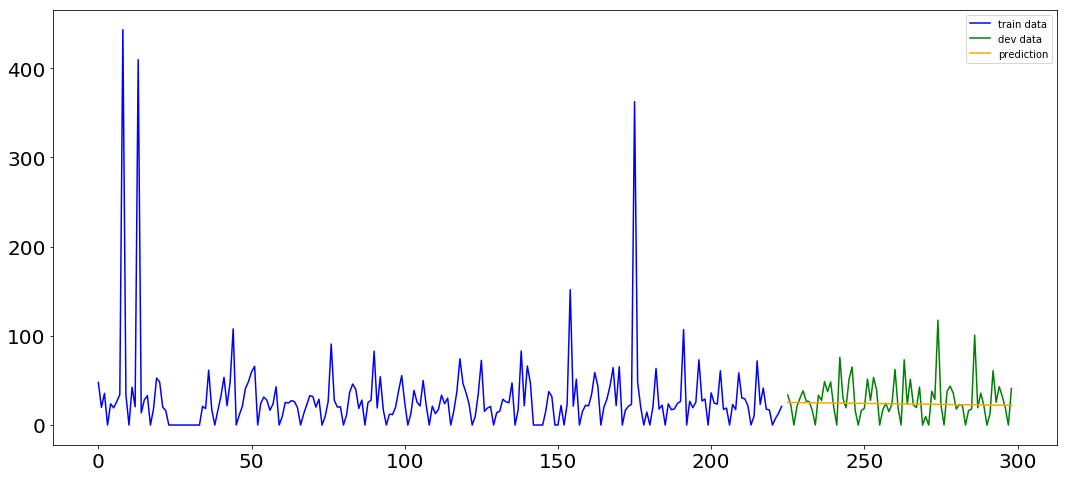

In [518]:
plot_prediction(X_train, y_train, X_dev, y_dev, pred_y)

at this point we should use test data to tune hiperparameters

**Polinomial regresion**

In [575]:
from sklearn.preprocessing import PolynomialFeatures 
  
poly_model = PolynomialFeatures(degree = 4) 
X_poly = poly_model.fit_transform(X_train) 

In [576]:
lr_model2 = LinearRegression()
lr_model2.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [577]:
y_poly_pred = model.predict(np.array(X_dev).reshape(-1,1))
#to be finished

2.2 Time Series decomposition

In [579]:
#some dates dont have data at this point, so we set to 0 as if any valid purchase was done that day
data = clean_sales_allH["Benefit"].resample('D').mean()

In [580]:
data.fillna(0, inplace = True)

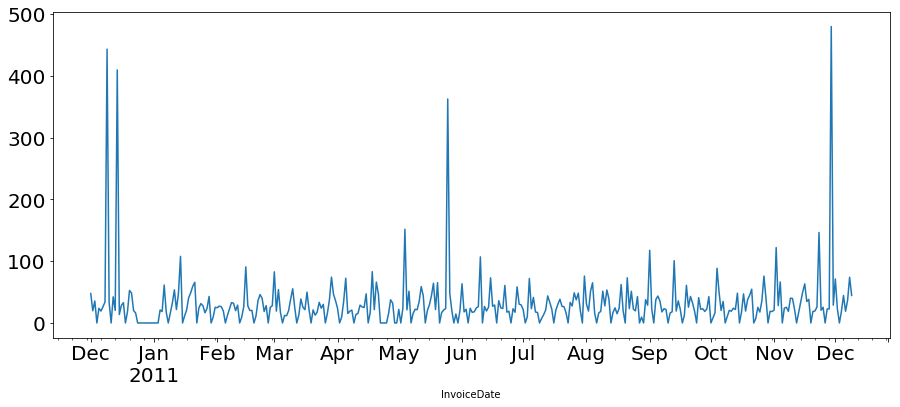

In [581]:
data.plot(figsize=(15, 6))
plt.show()

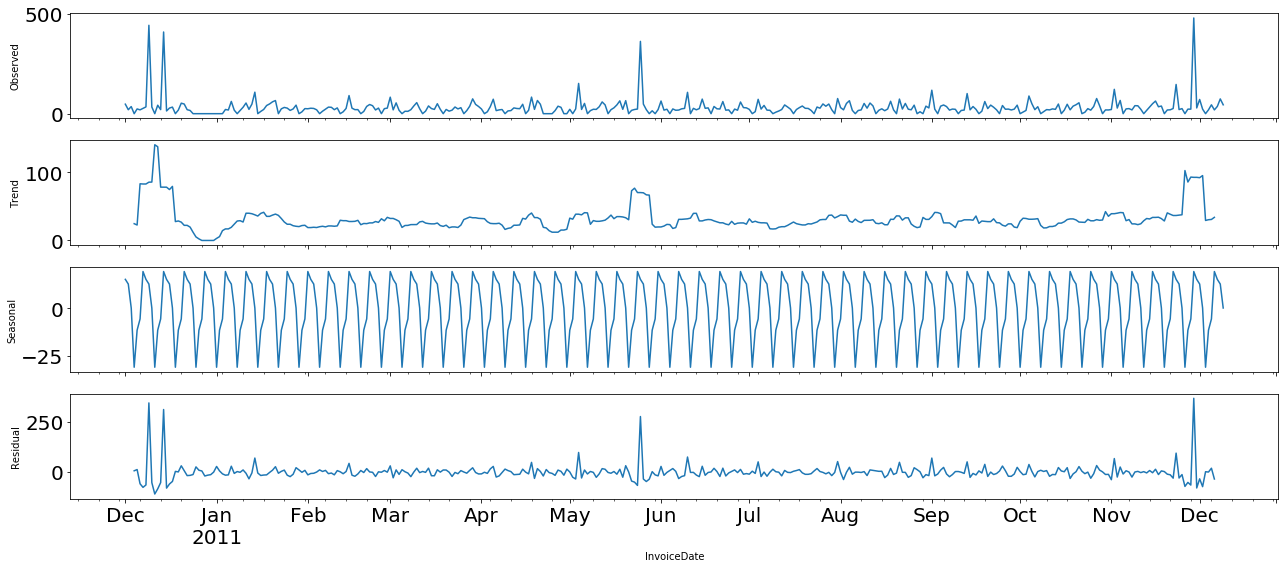

In [24]:
#Time series decomposition
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

### Next Steps
* Weekly lags

In [584]:
data = clean_sales_allH.resample("D").mean()

In [586]:
data.fillna(0, inplace=True)

In [ ]:
data.drop(["Quantity", "UnitPrice"], axis=1, inplace=True)

In [596]:
data.sort_index(inplace = True)

In [597]:
data.head()

,Holiday,Benefit
InvoiceDate,,
2010-12-01,0.0,47.686885
2010-12-02,0.0,19.807170
2010-12-03,0.0,35.536370
2010-12-04,0.0,0.000000
2010-12-05,0.0,23.763326


In [601]:
N_lags = 7 #weekly trend as seen in time series decomposition

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['Benefit-'+str(i)] = Xy_with_lags['Benefit'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(data, N_lags).iloc[N_lags:]
Xy_with_lags.head()

,Holiday,Benefit,Benefit-1,Benefit-2,Benefit-3,Benefit-4,Benefit-5,Benefit-6,Benefit-7
InvoiceDate,,,,,,,,,
2010-12-08,0.0,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370,19.807170,47.686885
2010-12-09,0.0,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370,19.807170
2010-12-10,0.0,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370
2010-12-11,0.0,0.000000,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000
2010-12-12,0.0,42.340326,0.000000,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326


In [607]:
#moving average (7 day week)
Xy_with_lags['mean'] = Xy_with_lags.drop(["Benefit-7"], axis = 1).mean(axis=1)

#Benefits W/o Seasonality
Xy_with_lags['seasonal'] = Xy_with_lags["Benefit"] - Xy_with_lags["mean"]

Text(0.5, 1.0, 'weekly average rolling window')

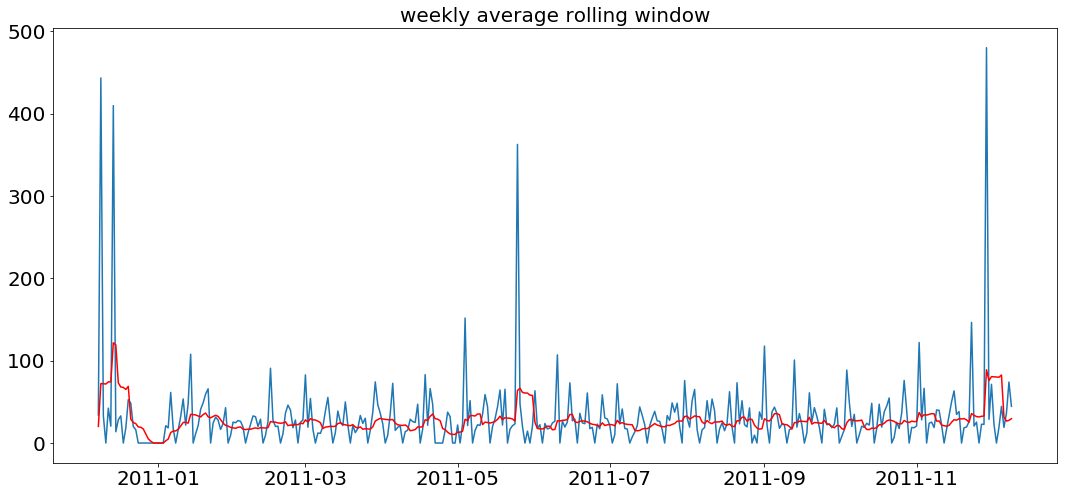

In [608]:
plt.plot(Xy_with_lags.index, Xy_with_lags["Benefit"])
plt.plot(Xy_with_lags.index, Xy_with_lags["mean"],color="red")
plt.title("weekly average rolling window",size=20)

In [609]:
Xy_with_lags["day"] = Xy_with_lags.index.day
Xy_with_lags["month"] = Xy_with_lags.index.month
Xy_with_lags["year"] = Xy_with_lags.index.year
Xy_with_lags["week"] = Xy_with_lags.index.weekofyear
Xy_with_lags["weekday"] = Xy_with_lags.index.dayofweek

In [611]:
Xy_with_lags.head()

,Holiday,Benefit,Benefit-1,Benefit-2,Benefit-3,Benefit-4,Benefit-5,Benefit-6,Benefit-7,mean,seasonal,day,month,year,week,weekday
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-08,0.0,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370,19.807170,47.686885,20.173440,13.820920,8,12,2010,49,2
2010-12-09,0.0,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370,19.807170,72.109988,371.171195,9,12,2010,49,3
2010-12-10,0.0,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000,35.536370,72.039485,-38.647108,10,12,2010,49,4
2010-12-11,0.0,0.000000,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326,0.000000,71.600765,-71.600765,11,12,2010,49,5
2010-12-12,0.0,42.340326,0.000000,33.392378,443.281183,33.994360,26.306367,19.228582,23.763326,74.187596,-31.847270,12,12,2010,49,6


In [639]:
X = Xy_with_lags[['Holiday',  'Benefit-1', 'Benefit-2', 'Benefit-3',
       'Benefit-4', 'Benefit-5', 'Benefit-6', 'Benefit-7', 'mean', 'seasonal',
       'day', 'month', 'year', 'week', 'weekday']]
y = Xy_with_lags['Benefit']

In [704]:
#We do this manually just to track properly what are we doing (so many datasets)

X_train = X[X.index < X.index[int(len(X.index)/100*60)]].copy()
y_train = y[y.index < y.index[int(len(y.index)/100*60)]].copy()

X_test = X[X.index >= X.index[int(len(X.index)/100*60)]].copy()
y_test = y[y.index >= y.index[int(len(y.index)/100*60)]].copy()

In [705]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [710]:
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [711]:
pred_y = reg.predict(X_test)

In [712]:
print("MSE: " ,mean_squared_error(y_test, pred_y))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, pred_y)))

MSE:  3.275267755486051e-27
RMSE:  5.722995505402789e-14


<function matplotlib.pyplot.show(*args, **kw)>

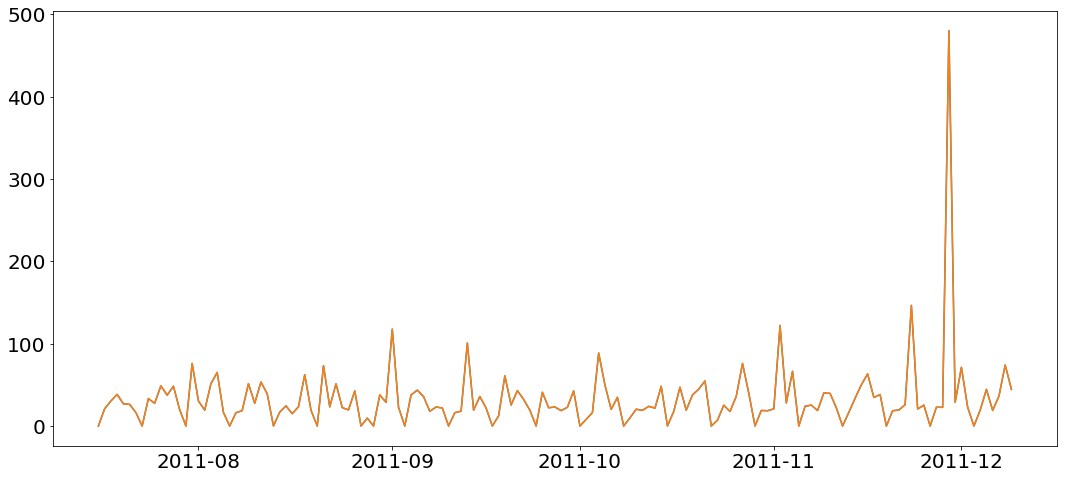

In [722]:
plt.plot(y_test)
plt.plot(X_test.index, pred_y)

plt.show

something must be wrong... 